<a href="https://colab.research.google.com/github/JimmyLiu8351/liulabtracking/blob/main/eye_test_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
import math

from google.colab.patches import cv2_imshow
from PIL import Image
from skimage.draw import line
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [4]:
def gradx(img):
    img = img.astype('int')
    rows, cols = img.shape
    # Use hstack to add back in the columns that were dropped as zeros
    return np.hstack( (np.zeros((rows, 1)), (img[:, 2:] - img[:, :-2])/2.0, np.zeros((rows, 1))) )

In [5]:
def grady(img):
    img = img.astype('int')
    rows, cols = img.shape
    # Use vstack to add back the rows that were dropped as zeros
    return np.vstack( (np.zeros((1, cols)), (img[2:, :] - img[:-2, :])/2.0, np.zeros((1, cols))) )

In [6]:
#Performs fast radial symmetry transform
#img: input image, grayscale
#radii: integer value for radius size in pixels (n in the original paper); also used to size gaussian kernel
#alpha: Strictness of symmetry transform (higher=more strict; 2 is good place to start)
#beta: gradient threshold parameter, float in [0,1]
#stdFactor: Standard deviation factor for gaussian kernel
#mode: BRIGHT, DARK, or BOTH
def frst(img, radii, alpha, beta, stdFactor, mode='BOTH'):
    mode = mode.upper()
    assert mode in ['BRIGHT', 'DARK', 'BOTH']
    dark = (mode == 'DARK' or mode == 'BOTH')
    bright = (mode == 'BRIGHT' or mode == 'BOTH')

    workingDims = tuple((e + 2*radii) for e in img.shape)

    #M and O working matrices
    O_n = np.zeros(workingDims, np.int16)
    M_n = np.zeros(workingDims, np.int16)

    #Calculate gradients
    gx = gradx(img)
    gy = grady(img)

    #Find gradient vector magnitude
    gnorms = np.sqrt( np.add( np.multiply(gx, gx) , np.multiply(gy, gy) ) )

    #Use beta to set threshold - speeds up transform significantly
    gthresh = np.amax(gnorms)*beta

    #Find x/y distance to affected pixels
    gpx = np.multiply(np.divide(gx, gnorms, out=np.zeros(gx.shape), where=gnorms!=0), radii).round().astype(int);
    gpy = np.multiply(np.divide(gy, gnorms, out=np.zeros(gy.shape), where=gnorms!=0), radii).round().astype(int);

    #Iterate over all pixels (w/ gradient above threshold)
    for coords, gnorm in np.ndenumerate(gnorms):
        if gnorm > gthresh:
            i, j = coords
            #Positively affected pixel
            if bright:
                ppve = (i+gpy[i,j]+radii, j+gpx[i,j]+radii)
                O_n[ppve] += 1
                M_n[ppve] += gnorm
            #Negatively affected pixel
            if dark:
                pnve = (i-gpy[i,j]+radii, j-gpx[i,j]+radii)
                O_n[pnve] -= 1
                M_n[pnve] -= gnorm

    

    #Abs and normalize O matrix
    O_n = np.abs(O_n)
    O_n = O_n / float(np.amax(O_n))

    #Normalize M matrix
    M_max = float(np.amax(np.abs(M_n)))
    M_n = M_n / M_max

    #Elementwise multiplication
    F_n = np.multiply(np.power(O_n, alpha), M_n)

    #Gaussian blur
    kSize = int( np.ceil( radii / 2 ) )
    kSize = kSize + 1 if kSize % 2 == 0 else kSize

    S = cv2.GaussianBlur(F_n, (kSize, kSize), int( radii * stdFactor ))
    
    return S[radii:-radii,radii:-radii]

In [7]:
def rough_corneal_remove(gray_frame, replace_val):
    # roughly removing corneal reflection
    blur_frame = cv2.blur(gray_frame, (5, 5))
    ret, thresh_frame = cv2.threshold(blur_frame, 100, 255, cv2.THRESH_BINARY)

    for (x, y), value in np.ndenumerate(thresh_frame):
        if value > 0:
            gray_frame[x, y] = replace_val
    
    return cv2.blur(gray_frame, (5, 5))

In [8]:
def estimate(frame, radius_lst):
    # convert frame to grayscale
    if len(frame.shape) != 2:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame

    gray_frame = rough_corneal_remove(gray_frame, np.mean(gray_frame))

    #frst
    frst_sum = np.zeros(gray_frame.shape)
    for i in radius_lst:
        result = frst(gray_frame, i, 2, 0.2, 0, mode='DARK')
        frst_sum = np.add(frst_sum, result)

    # argmin finds the min index as if frst_sum is flattened,
    # so we have to reverse that using unravel_index
    eye_estimate = np.unravel_index(frst_sum.argmin(), frst_sum.shape)[::-1]
    
    return eye_estimate

In [133]:
def starburst(frame, eye):
    PIVOT_ANGLE = 15
    LINE_LENGTH = 30
    DETECTION_THRESHOLD = 4
    CORNEAL_REFLECTION_SEARCH_SIZE = 15

    # convert frame to grayscale
    if len(frame.shape) != 2:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray_frame = frame

    gray_frame = cv2.blur(gray_frame, (5, 5))

    test_frame = frame.copy()

    feature_points = []
    distances = []

    for degree in range(0, 360, PIVOT_ANGLE):

        radian = degree * math.pi / 180
        edge = (int(eye[0] + LINE_LENGTH * math.cos(radian)), 
                int(eye[1] + LINE_LENGTH * math.sin(radian)))
        
        line_points = [tupl for tupl in createLineIterator(eye, edge, gray_frame)]
        derivative = []

        prev_intensity = None
        for tupl in line_points:
            if prev_intensity is not None:
                derivative.append(tupl[2] - prev_intensity)            
            prev_intensity = tupl[2]
        
        next_transition = 0
        for i in range(len(derivative)):
            # skip to the next transition if there is one
            if next_transition > i:
                continue
            if derivative[i] > DETECTION_THRESHOLD:
                corneal_reflection = False
                peak_idx = i
                peak_end = False
                for j in range(i + 1, len(derivative)):
                    # detecting maximum slope
                    if derivative[j] > derivative[peak_idx] and not peak_end:
                        peak_idx = j
                    # detecting end of transition
                    elif derivative[j] < DETECTION_THRESHOLD and not peak_end:
                        peak_end = True
                    # detecting if reached another transition:
                    elif derivative[j] > DETECTION_THRESHOLD and peak_end:
                        next_transition = j
                        break
                    # detecting corneal reflection
                    elif derivative[j] < -1 * DETECTION_THRESHOLD:
                        corneal_reflection = True
                    # stop if too long distance
                    elif j - peak_idx > CORNEAL_REFLECTION_SEARCH_SIZE:
                        break

                '''
                if corneal_reflection:
                    cv2.circle(test_frame, (tuple(line_points[peak_idx][:-1])), 1, (0, 255, 0))
                else:
                    cv2.circle(test_frame, (tuple(line_points[peak_idx][:-1])), 1, (0, 0, 255))
                '''
                if not corneal_reflection:
                    feature_points.append(line_points[peak_idx][:-1])

                # end outside loop, there's no next_transition
                if next_transition == 0:
                    break    
        

    return np.array(feature_points)



In [11]:
# opening the video in videocapture

file_path = "/content/gdrive/MyDrive/mouse_eye_tracking/fixedSFblink.avi"
vidcap = cv2.VideoCapture(file_path)

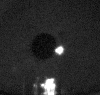

In [130]:
# reading the frame from video

for i in range(200):
    ret, frame = vidcap.read()

#ret, frame = vidcap.read()

frame = frame[80:175, 100:200]
cv2_imshow(frame)

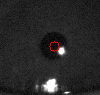

In [93]:
# eye estimate example
eye = estimate(frame, [14, 16, 18])
cv2.circle(frame, eye, 5, (0, 0, 255))
cv2_imshow(frame)

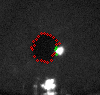

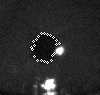

In [122]:
# starburst example
eye = estimate(frame, [10, 12, 14])
contour = starburst(frame, eye)

for point in contour:
    cv2.circle(frame, tuple(point), 1, (255, 255, 255))

cv2_imshow(frame)


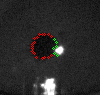

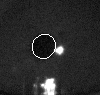

In [131]:
# elippse fitting example
eye = estimate(frame, [10, 12, 14])
contour = starburst(frame, eye)

fitted_ellipse = cv2.fitEllipse(contour)
cv2.ellipse(frame, fitted_ellipse, (255, 255, 255), 1)
cv2_imshow(frame)

In [135]:
progress_bar = tqdm(total=int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
ret, frame = vidcap.read()
frame = frame[80:175, 100:200]
while ret:
    eye = estimate(frame, [10, 12, 14])
    for i in range(5):
        contour = starburst(frame, eye)
        fitted_ellipse = cv2.fitEllipse(contour)
        ret, frame = vidcap.read()
        frame = frame[80:175, 100:200]
        progress_bar.update(1)



  0%|          | 0/24002 [00:00<?, ?it/s]

  0%|          | 6/24002 [00:00<10:02, 39.83it/s]

  0%|          | 14/24002 [00:00<08:33, 46.75it/s]

  0%|          | 21/24002 [00:00<08:40, 46.11it/s]

  0%|          | 29/24002 [00:00<07:37, 52.37it/s]

  0%|          | 36/24002 [00:00<08:04, 49.46it/s]

  0%|          | 43/24002 [00:00<07:24, 53.86it/s]

  0%|          | 50/24002 [00:00<06:56, 57.55it/s]

  0%|          | 56/24002 [00:01<07:46, 51.36it/s]

  0%|          | 62/24002 [00:01<07:31, 52.99it/s]

  0%|          | 68/24002 [00:01<07:22, 54.08it/s]

  0%|          | 76/24002 [00:01<07:36, 52.41it/s]

  0%|          | 84/24002 [00:01<06:53, 57.88it/s]

  0%|          | 91/24002 [00:01<07:32, 52.81it/s]

  0%|          | 98/24002 [00:01<07:02, 56.61it/s]

  0%|          | 105/24002 [00:01<06:38, 59.94it/s]

  0%|          | 112/24002 [00:02<07:25, 53.61it/s]

  0%|          | 119/24002 [00:02<06:54, 57.58it/s]

  1%|          | 126/24002 [00:02<07:26, 53.46it/s]

  1%|          |

KeyboardInterrupt: ignored